In [26]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import special
import numpy as np
import pandas as pd

import os
import glob
import itertools as it
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from mvee import EllipsoidTool as ET

In [2]:
wsrc = '../clean2/'
tsrc = '../watershed/'
rsrc = '../rotated/'
dst = '../traditional/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

walnut_batch = sorted(glob.glob( wsrc + '*/' ))
bidx = 1
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))

bname = walnut_batch[bidx].split('/')[-2]

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

../traditional/2014SBa_R1_T3/


In [3]:
widx = 2
print(walnut_files[widx])

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))

img = tf.imread(walnut_files[widx])

if True:
    air  = tf.imread(tissuefiles[0])
    meat = tf.imread(tissuefiles[1])
    shell= tf.imread(tissuefiles[2])
    vein = tf.imread(tissuefiles[3])

mxval = 2**(8*img.itemsize)

../clean2/2014SBa_R1_T3/2014SBa_R1_T3_003.tif
2014SBa_R1_T3_003


### Load rotations and phenotypes

In [4]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

In [5]:
wmean = data[0]
rotxyz = data[10:13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
chnutarea, chnutvol, _ = data[20]

In [6]:
chnutaratio = chnutarea/nutarea
chnutvratio = chnutvol/nutvol

In [7]:
print('Nut volume:\t', np.round(nutvol, 2), 'mm^3')
print('Approx by a box of size:\t', np.round(np.cbrt(nutvol),2), 'mm')

Nut volume:	 23153.1 mm^3
Approx by a box of size:	 28.5 mm


### Other phenotypes

In [8]:
nutva3d = (nutarea ** 3)/(36*np.pi*nutvol**2)
nutferet = np.max(feretd)/np.min(feretd)
nutsphr = np.cbrt(36 * np.pi * nutvol**2)/nutarea
shellrug = 1./nutsphr

In [9]:
tvols = np.zeros(4)
for i,tissue in enumerate([air, meat, shell, vein]):
    tvols[i] = np.sum(tissue > 0)

tvols *= resol**3
tvolr = tvols/nutvol
print(np.round(tvolr*100,2), np.sum(tvolr), sep='\n')

[38.79 29.42 18.57 13.23]
0.9999994334509911


### Sphericity

In [36]:
c,b,a = np.sort(feretd)
a *= 0.5;b *= 0.5;c *= 0.5

if a == c:
    area = 4*np.pi*a*a
else:
    t = np.arccos(c/a)
    s = np.arccos(c/b)
    k = np.sin(s)/np.sin(t)

    ellarea = c*c/(a*a)*special.ellipkinc(t, k*k) + np.sin(t)*np.sin(t)*special.ellipeinc(t, k*k)
    ellarea *= 2*np.pi*a*b/np.sin(t)
    ellarea += 2*np.pi*c*c

ellvolume = 4*np.pi*a*b*c/3

wadell = np.cbrt(36*np.pi*ellvolume*ellvolume)/ellarea

In [40]:
krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(a*b))
janke = c/np.sqrt(np.sum(feretd**2)/3)

print(np.round([nutsphr, wadell, krumbein, corey, sneed, janke, c/a],3), sep='\t')

[0.585 0.99  0.855 0.859 0.904 0.446 0.773]


### Kernel lobeyness

In [12]:
bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
kerarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
kervoxarea = np.sum(border)

print('Border made of\t', kervoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(kerarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(kerarea),2), 'mm')

Border made of	 719608 pixels

Nut surface area:	 6836.64 mm^2
Approx by a square of size:	 82.68 mm


In [13]:
datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

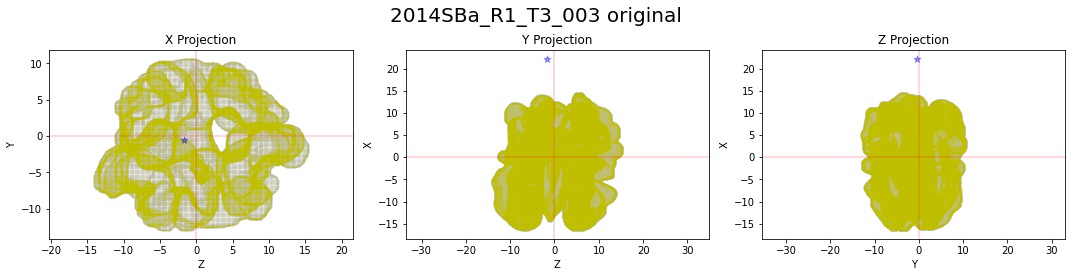

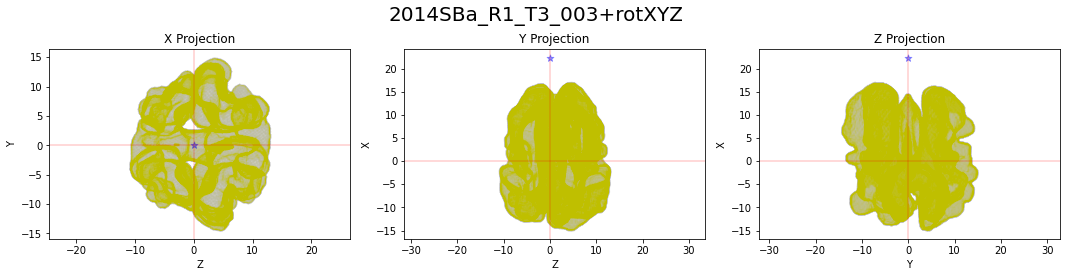

In [14]:
fig, ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='b', alpha=.4);

fig, ax = wnut.plot_3Dprojections(mcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

In [15]:
kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)
print(kmaxes - kminis)

[31.90338149 29.33698229 23.9061085 ]


In [16]:
khull = spatial.ConvexHull(mcoords.T)
kerlob = khull.area/kerarea
chkervratio = khull.volume/tvols[1]
print(kerlob, 1/kerlob, sep='\t')

0.39472920949641666	2.5333823186679525


### Shell thickness

In [17]:
shelldist = ndimage.distance_transform_cdt(shell, 'taxicab')
cval = np.max(shelldist)

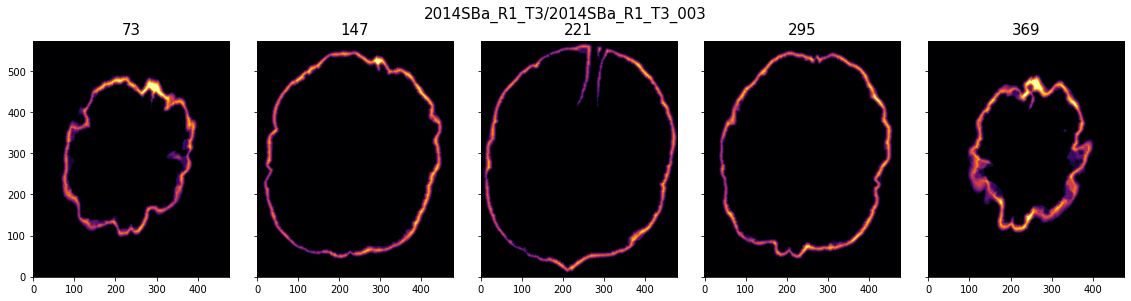

In [18]:
thrs = (np.linspace(0,shell.shape[1],7).astype(int))[1:-1]
ssp = [np.s_[:,t,:] for t in thrs]

fig, ax = plt.subplots(1,len(thrs),figsize=(16,4), sharex=True, sharey=True)

for i in range(len(thrs)):
    ax[i].imshow(shelldist[ssp[i]], cmap='inferno', origin='lower', vmax = cval//2)
    ax[i].set_title(thrs[i], fontsize=fs)
    
fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

In [19]:
dists = shelldist[shelldist > 2]
sthick = 2*np.mean(dists)
print(sthick)
print(sthick*resol)

11.187932365741686
0.8491640665597939


# Data saving

In [44]:
tradpheno = np.hstack((feretd,
                       nutvol,
                       nutva3d, # rugosity ** 3
                       nutferet,
                       1./nutferet, # equancy
                       nutarea,
                       nutsphr, # wadell
                       chnutarea,
                       chnutvol,
                       chnutaratio,
                       chnutvratio,
                       1./chnutaratio,
                       1./chnutvratio,
                       krumbein,
                       corey,
                       sneed,
                       janke,
                       wadell,
                       tvols,
                       tvolr,
                       shellrug, # 1/wadell
                       sthick*resol,
                       kmaxes - kminis,
                       kerarea,
                       khull.volume,
                       khull.area,
                       kerlob,
                       1./kerlob,
                       chkervratio,
                       1./chkervratio))
print(tradpheno.shape)

filename = wdst + fname + '_trad.csv'
print(filename)
foo = pd.DataFrame([bname, fname.split('_')[-1], *tradpheno]).T
foo.to_csv(filename, header=False, index=False)

(40,)
../traditional/2014SBa_R1_T3/2014SBa_R1_T3_003_trad.csv


In [21]:
bar = pd.read_csv(filename, header=None, dtype={1:str})

In [22]:
bar

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2014SBa_R1_T3,003,43.511117,35.194017,33.628451,23153.097373,4.990945,1.293878,0.77287,6713.532758,...,31.903381,29.336982,23.906108,6836.641267,12204.485154,2698.622003,0.394729,2.533382,1.791898,0.558068
